In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys

codebase = '~/source/701-simplicity-bias'
sys.path.append(codebase)
from synthetic_data.linear_slabs import LinearSlabDataset
from trainers import Trainer
from logging import Logger, StreamHandler
import datetime
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
logger = Logger('trainer')
logger.setLevel('DEBUG')
logger.addHandler(StreamHandler())

lms_5_config = dict(
    num_samples=110000,
    num_dim=2,
    margins=0.1,
    width=1.0,
    random_orthonormal_transform=True,
    slabs=np.array([2, 5]),
    noise_proportions=np.array([0.1, 0])
)
lms_5_equivariance_config = {**lms_5_config, 'slab_probabilities': [[1.0, 1.0], [0.125, 0.5, 0.75, 0.5, 0.125]]}
lms_5_50dim_equivariance_config = {**lms_5_config, 'num_dim': 50, 'slabs': np.array([2] + [5] * 49),
                                   'slab_probabilities': [[1.0, 1.0]] + [[0.125, 0.5, 0.75, 0.5, 0.125]] * 49,
                                   'noise_proportions': np.array([0.1] + [0] * 49)}
lms_7_50dim_equivariance_config = {**lms_5_config, 'num_dim': 50, 'slabs': np.array([2] + [7] * 49),
                                   'slab_probabilities': [[1.0, 1.0]] + [
                                       [1 / 16.0, 0.25, 7 / 16.0, 0.5, 7 / 16.0, 0.25, 1 / 16.0]] * 49,
                                   'noise_proportions': np.array([0.1] + [0] * 49)}
lms_5_uniform_config = {**lms_5_config, 'slab_probabilities': [[1.0, 1.0], [1.0 / 3, 0.5, 1.0 / 3, 0.5, 1.0 / 3]]}
lms_5_equivariance_data = LinearSlabDataset.generate(**lms_5_equivariance_config)
lms_5_50dim_equivariance_data = LinearSlabDataset.generate(**lms_5_50dim_equivariance_config)
lms_7_50dim_equivariance_data = LinearSlabDataset.generate(**lms_7_50dim_equivariance_config)
lms_5_uniform_data = LinearSlabDataset.generate(**lms_5_uniform_config)
equiv_train, equiv_val = lms_5_equivariance_data.split_train_val(100000)
equiv_50dim_train, equiv_50dim_val = lms_5_50dim_equivariance_data.split_train_val(100000)
equiv_7_50dim_train, equiv_7_50dim_val = lms_7_50dim_equivariance_data.split_train_val(100000)
uniform_train, uniform_val = lms_5_uniform_data.split_train_val(100000)


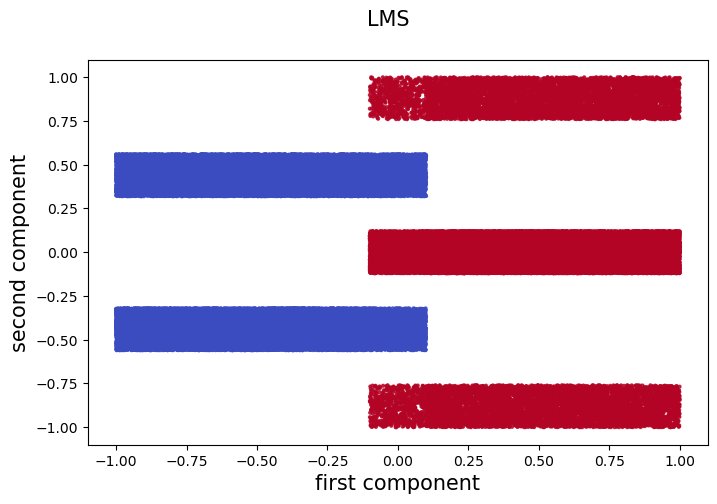

In [53]:
lms_5_equivariance_data.visualize()

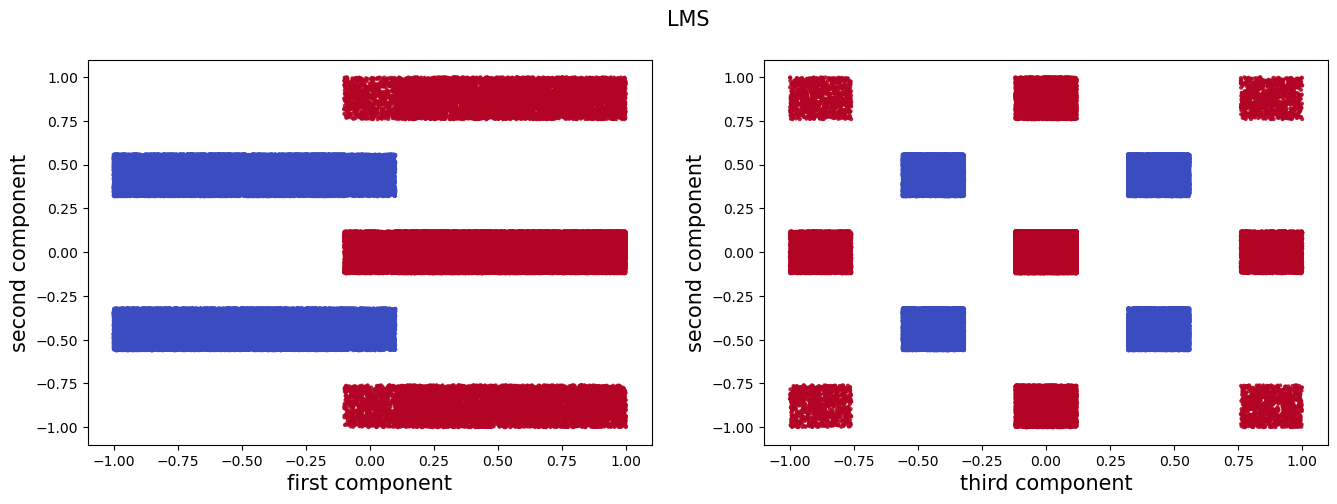

In [54]:
lms_5_50dim_equivariance_data.visualize()

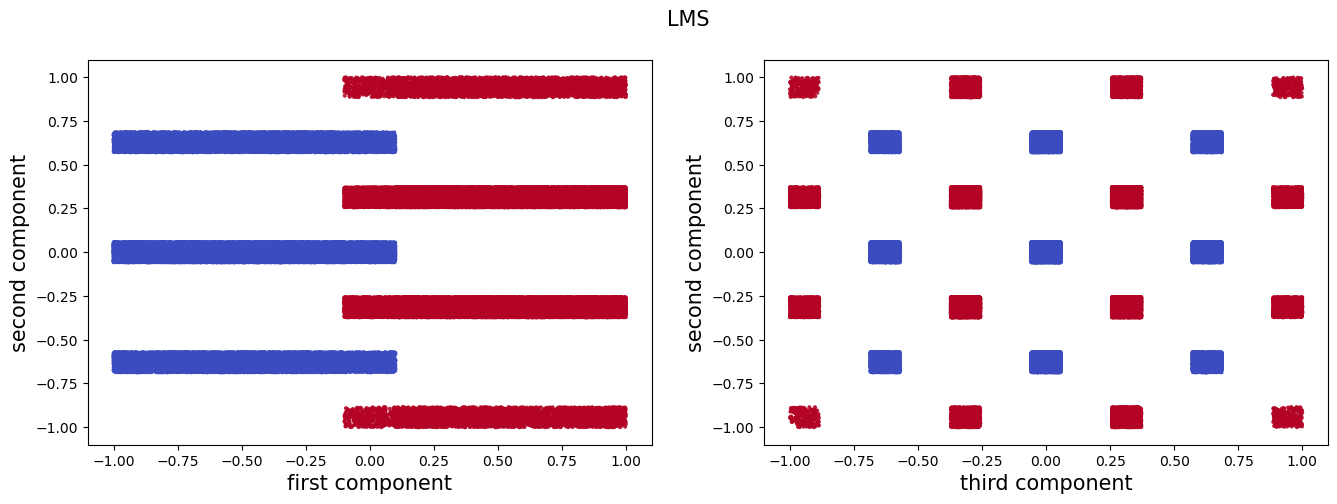

In [63]:
lms_7_50dim_equivariance_data.visualize()

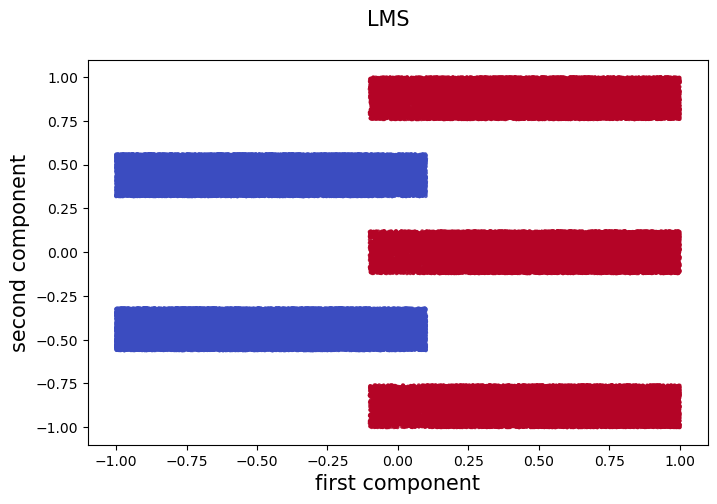

In [55]:
lms_5_uniform_data.visualize()

In [56]:
trainer_config = dict(
    model=dict(
        cls='fcn',
        num_layers=2,
        input_dim=2,
        output_dim=2,
        latent_dim=100,
        use_bn=False,
        dropout_probability=0.0,
        linear_init=None
    ),
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/lms7_noisy_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    logger=logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-5
    )
)
equivariance_data_config = dict(
    train_data=dict(
        dataset=equiv_train,
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=equiv_val,
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=equiv_train.randomize_axes((0,)),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=equiv_train.randomize_axes((1,)),
            batch_size=256,
            shuffle=False
        )
    )
)

In [57]:
equiv_trainer = Trainer(**trainer_config, **equivariance_data_config)
equiv_trainer.run()

model: Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)
Step 0: Loss 0.728287398815155
Evaluating ...


Started, logging to ./training_logs/lms7_noisy_10252153/...


Step: 0
Train/AUC: 0.3539768239578327
Train/AverageLoss: 0.698599704246521
Train/Accuracy: 0.4978199899196625
Val/AUC: 0.3545967686352969
Val/AverageLoss: 0.6982455741882324
Val/Accuracy: 0.5029000043869019
s_randomized/AUC: 0.5533556792701207
s_randomized/AverageLoss: 0.69334481716156
s_randomized/Accuracy: 0.4978199899196625
sc_randomized/AUC: 0.3125662389591761
sc_randomized/AverageLoss: 0.6999574354553223
sc_randomized/Accuracy: 0.4978199899196625
Step 1000: Loss 0.04993118345737457
Evaluating ...
Step: 1000
Train/AUC: 0.9978325573977831
Train/AverageLoss: 0.060324351187050346
Train/Accuracy: 0.967769980430603
Val/AUC: 0.99805841468507
Val/AverageLoss: 0.057314187240600584
Val/Accuracy: 0.9684000015258789
s_randomized/AUC: 0.5195072004240772
s_randomized/AverageLoss: 3.693910329437256
s_randomized/Accuracy: 0.5201600193977356
sc_randomized/AUC: 0.9945467043350307
sc_randomized/AverageLoss: 0.09559896790504456
sc_randomized/Accuracy: 0.9510599970817566
Step 2000: Loss 0.023392686620

In [58]:
trainer_50dim_config = dict(
    model=dict(
        cls='fcn',
        num_layers=2,
        input_dim=50,
        output_dim=2,
        latent_dim=100,
        use_bn=False,
        dropout_probability=0.0,
        linear_init=None
    ),
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/lms7_noisy_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    logger=logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-5
    )
)
equiv_50dim_data_config = dict(
    train_data=dict(
        dataset=equiv_50dim_train,
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=equiv_50dim_val,
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=equiv_50dim_train.randomize_axes((0,)),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=equiv_50dim_train.randomize_axes((1,)),
            batch_size=256,
            shuffle=False
        )
    )
)

In [59]:
equiv_50dim_trainer = Trainer(**trainer_50dim_config, **equiv_50dim_data_config)
equiv_50dim_trainer.run()

model: Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)
Step 0: Loss 0.6961127519607544
Evaluating ...


Started, logging to ./training_logs/lms7_noisy_10252153/...


Step: 0
Train/AUC: 0.441893327304951
Train/AverageLoss: 0.6956645331764221
Train/Accuracy: 0.4599500000476837
Val/AUC: 0.4436355247634587
Val/AverageLoss: 0.6957227023124695
Val/Accuracy: 0.4668000042438507
s_randomized/AUC: 0.500811437026827
s_randomized/AverageLoss: 0.6933844213294983
s_randomized/Accuracy: 0.5014100074768066
sc_randomized/AUC: 0.4417758450821943
sc_randomized/AverageLoss: 0.695674699420929
sc_randomized/Accuracy: 0.4602400064468384
Step 1000: Loss 0.0783986896276474
Evaluating ...
Step: 1000
Train/AUC: 0.995106821741654
Train/AverageLoss: 0.09000711231708526
Train/Accuracy: 0.9523599743843079
Val/AUC: 0.9951009065954912
Val/AverageLoss: 0.0903383448600769
Val/Accuracy: 0.9531000256538391
s_randomized/AUC: 0.5005468784229165
s_randomized/AverageLoss: 3.606960166473389
s_randomized/Accuracy: 0.500469982624054
sc_randomized/AUC: 0.9950944867922729
sc_randomized/AverageLoss: 0.09011367574453354
sc_randomized/Accuracy: 0.9521300196647644
Step 2000: Loss 0.068924717605113

In [66]:
trainer_7_50dim_config = dict(
    model=dict(
        cls='fcn',
        num_layers=2,
        input_dim=50,
        output_dim=2,
        latent_dim=100,
        use_bn=False,
        dropout_probability=0.0,
        linear_init=None
    ),
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/lms7_noisy_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    logger=logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-5
    )
)
equiv_7_50dim_data_config = dict(
    train_data=dict(
        dataset=equiv_7_50dim_train,
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=equiv_7_50dim_val,
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=equiv_7_50dim_train.randomize_axes((0,)),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=equiv_7_50dim_train.randomize_axes((1,)),
            batch_size=256,
            shuffle=False
        )
    )
)

In [67]:
equiv_7_50dim_trainer = Trainer(**trainer_7_50dim_config, **equiv_7_50dim_data_config)
equiv_7_50dim_trainer.run()

model: Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)
Step 0: Loss 0.692682147026062
Evaluating ...


Started, logging to ./training_logs/lms7_noisy_10252200/...


Step: 0
Train/AUC: 0.44141358309764517
Train/AverageLoss: 0.6963609314155579
Train/Accuracy: 0.4715900123119354
Val/AUC: 0.4421146588001649
Val/AverageLoss: 0.6964441210746765
Val/Accuracy: 0.4690000116825104
s_randomized/AUC: 0.5002940307465432
s_randomized/AverageLoss: 0.693736177482605
s_randomized/Accuracy: 0.5009599924087524
sc_randomized/AUC: 0.4416817133255744
sc_randomized/AverageLoss: 0.6963521632766724
sc_randomized/Accuracy: 0.47189000248908997
Step 1000: Loss 0.12266140431165695
Evaluating ...
Step: 1000
Train/AUC: 0.9947450599344764
Train/AverageLoss: 0.09302089234828949
Train/Accuracy: 0.9503300189971924
Val/AUC: 0.9951248794360831
Val/AverageLoss: 0.09050911612510681
Val/Accuracy: 0.9510999917984009
s_randomized/AUC: 0.5000603952765862
s_randomized/AverageLoss: 3.557809175262451
s_randomized/Accuracy: 0.500220000743866
sc_randomized/AUC: 0.9947251754434133
sc_randomized/AverageLoss: 0.09320526297092438
sc_randomized/Accuracy: 0.9501500129699707
Step 2000: Loss 0.08320973

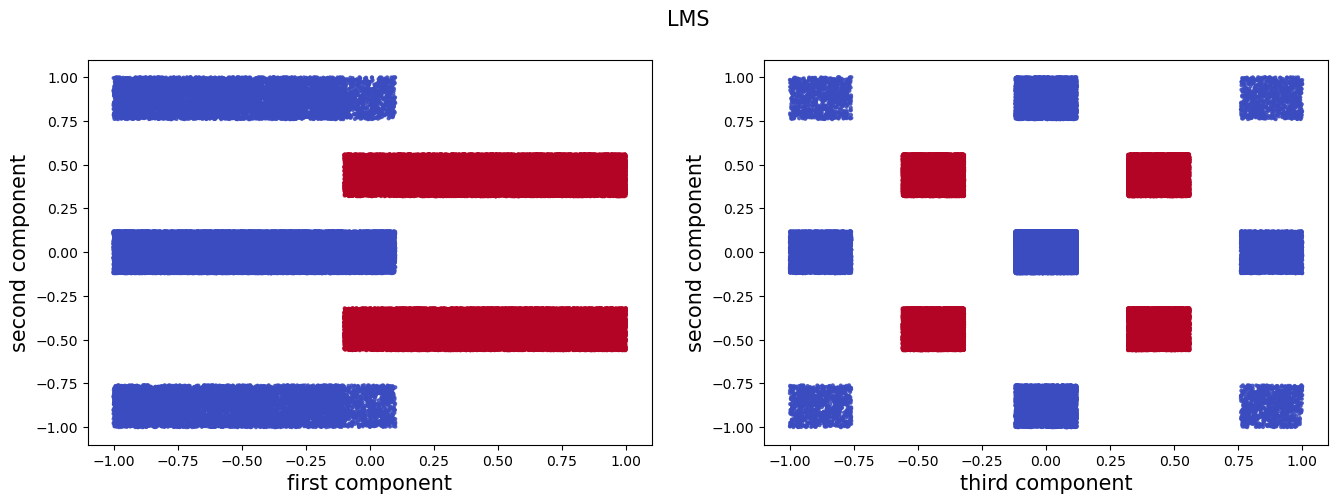

In [78]:
original_noisy_lms5 = LinearSlabDataset.from_file('/Users/tianwen/source/701-simplicity-bias/original_code_noisy_lms5_data.npz')
original_lms5_train, original_lms5_val = original_noisy_lms5.split_train_val(100000)
original_noisy_lms5.visualize()

In [79]:
trainer_50dim_original_config = dict(
    model=dict(
        cls='fcn',
        num_layers=2,
        input_dim=50,
        output_dim=2,
        latent_dim=100,
        use_bn=False,
        dropout_probability=0.0,
        linear_init=None
    ),
    loss=dict(cls='CE'),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    evaluate_interval=1000,
    save_interval=0,
    work_dir='./training_logs/lms7_noisy_{}/'.format(datetime.datetime.now().strftime('%m%d%H%M')),
    loss_eps=1e-2,
    logger=logger,
    max_steps=100000,
    optimizer=dict(
        cls='SGD',
        lr=0.1,
        weight_decay=5.0e-5
    )
)
equiv_50dim_original_data_config = dict(
    train_data=dict(
        dataset=original_lms5_train,
        batch_size=256,
        shuffle=True
    ), val_data=dict(
        dataset=original_lms5_val,
        batch_size=256,
        shuffle=False
    ),
    additional_data=dict(
        s_randomized=dict(
            dataset=original_lms5_train.randomize_axes((0,)),
            batch_size=256,
            shuffle=False
        ),
        sc_randomized=dict(
            dataset=original_lms5_train.randomize_axes((1,)), # BUG: here
            batch_size=256,
            shuffle=False
        )
    )
)
original_lms5_trainer = Trainer(**trainer_50dim_original_config, **equiv_50dim_original_data_config)

model: Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)


In [80]:
original_lms5_trainer.run()

Step 0: Loss 0.6923403739929199
Evaluating ...


Started, logging to ./training_logs/lms7_noisy_10252227/...


Step: 0
Train/AUC: 0.5014766269402149
Train/AverageLoss: 0.6933481334114074
Train/Accuracy: 0.5008900165557861
Val/AUC: 0.5004800604800604
Val/AverageLoss: 0.6933888292312622
Val/Accuracy: 0.498199999332428
s_randomized/AUC: 0.5017186695959814
s_randomized/AverageLoss: 0.693378742389679
s_randomized/Accuracy: 0.5005599856376648
sc_randomized/AUC: 0.501130187060395
sc_randomized/AverageLoss: 0.6933587547683716
sc_randomized/Accuracy: 0.5004799962043762
Step 1000: Loss 0.10414279252290726
Evaluating ...
Step: 1000
Train/AUC: 0.9948587338154523
Train/AverageLoss: 0.09214778612613678
Train/Accuracy: 0.9502000212669373
Val/AUC: 0.9950500350500351
Val/AverageLoss: 0.0914347059726715
Val/Accuracy: 0.9509000182151794
s_randomized/AUC: 0.5016233683740241
s_randomized/AverageLoss: 3.5743729972839358
s_randomized/Accuracy: 0.502269983291626
sc_randomized/AUC: 0.9948377796106243
sc_randomized/AverageLoss: 0.09235788405418396
sc_randomized/Accuracy: 0.9499899744987488
Step 2000: Loss 0.108666062355